# LoC Data Package Tutorial: Stereograph Card Collection

This notebook will demonstrate basic usage of using the Pyton library `boto3` for interacting with [data packages from the Library of Congress](https://labs.loc.gov/data/) via the [Stereograph Card Images Data Package](https://labs.loc.gov/data/explore/stereographs/) which is derived from the Library's [Stereograph Cards collection](https://www.loc.gov/collections/stereograph-cards/about-this-collection/). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download and display images from a data package](#Download-and-display-images)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First, we will select [Stereograph Card Images Data Package](https://labs.loc.gov/data/explore/stereographs/) and output a summary of it's contents

In [1]:
import io
import json
import math

import boto3                            # for interacting with Amazon S3 (where the data is stored)
import pandas as pd                     # for reading, manipulating, and displaying data

from helpers import get_s3_bucket_stats

BUCKET_NAME = 'data.labs.loc.gov' # The name of public S3 bucket

# Connect to Amazon S3
s3 = boto3.client('s3')

# This is the name of the data package from the list above; note the trailing slash
DATA_PACKAGE = 'stereographs/'

stats = get_s3_bucket_stats(s3, BUCKET_NAME, DATA_PACKAGE)

# Convert to Pandas DataFrame and show table
pd.DataFrame(stats)

,FileType,Count,Size
0,.jpg,"40,594",4.13GB
1,.json,5,323MB
2,.jsonl,1,308MB
3,.csv,2,153MB
4,.zip,1,95MB
5,.html,3,14MB
6,.txt,5,6MB
7,.md,3,26KB


## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' subject values, then filter by a particular subject.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's `metadata.json` file:

In [5]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}metadata.json')
contents = obj.get('Body', '[]').read() # Read contents as a string
data = json.loads(contents) # Parse string as JSON
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 39,532 entries.


Next let's convert to pandas DataFrame and print the available properties

In [6]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

access_restricted, aka, campaigns, contributor, coordinates, date, description, digitized, extract_timestamp, group, hassegments, id, image_url, index, language, latlong, location, location_str, locations, lonlat, mime_type, online_format, original_format, other_title, partof, reproductions, resources, shelf_id, site, subject, timestamp, title, unrestricted, url, item, related, dates, number, number_former_id, number_lccn, number_oclc, number_carrier_type, number_source_modified, type, location_city, location_country, location_state, location_county, manifest_id


Next print the top 20 most frequent Subjects in this dataset

In [10]:
# Since "subject" are a list, we must "explode" it so there's just one subject per row
# We convert to DataFrame so it displays as a table
df['subject'].explode().value_counts().iloc[:20].to_frame()

,subject
stereographs,37427
photographic prints,33217
albumen prints,3596
new york (state),2367
,2030
new york,1906
united states,1618
history,1404
italy,1381
civil war,1281


Now we filter the results to only those items with subject "washington (d.c.)"

In [12]:
df_by_subject = df.explode('subject')
dc_set = df_by_subject[df_by_subject.subject == 'washington (d.c.)']
print(f'Found {dc_set.shape[0]:,} items with subject "washington (d.c.)"')

Found 1,077 items with subject "washington (d.c.)"


## Download and display images

First, we download the file manifest to retrieve the image filenames

In [14]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}manifest.json')
contents = obj.get('Body', '[]').read() # Read contents as a string
data = json.loads(contents) # Parse string as JSON
files = [dict(zip(data["cols"], row)) for row in data["rows"]] # zip columns and rows
files_by_id = dict([(f['item_id'], f['filename']) for f in files]) # create a dict that we can use to easily look up filenames
print(f'Loaded manifest file with {len(files):,} entries.')

Loaded manifest file with 39,597 entries.


Finally we will download and display the first 4 images that have subject "washington (d.c.)"

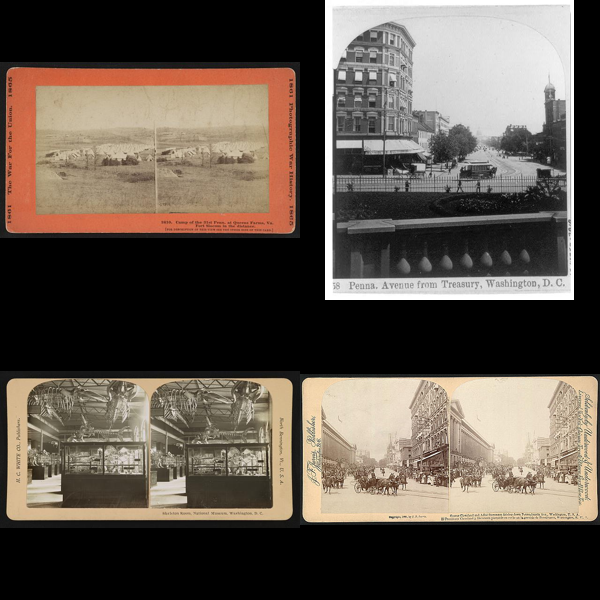

In [18]:
from IPython.display import display     # for displaying images
from PIL import Image                   # for creating, reading, and manipulating images

count = 4

# Define image dimensions
image_w = 600
image_h = 600
cols = math.ceil(count / 2.0)
rows = math.ceil(count / 2.0)
cell_w = image_w / cols
cell_h = image_h / rows

# Create base image
base_image = Image.new("RGB", (image_w, image_h))

# Loop through image URLs
i = 0
for i, row in dc_set.iterrows():
    if i >= count:
        break
    # Check to see if item has image file
    item_id = row["id"]
    if item_id not in files_by_id:
        continue
    image_filename = files_by_id[item_id]

    # Downoad the image to memory
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}data/{image_filename}')
    image_filestream = io.BytesIO(obj.get('Body').read())

    # And read the image data
    im = Image.open(image_filestream)

    # Resize it as a thumbnail
    im.thumbnail((cell_w, cell_h))
    tw, th = im.size

    # Position it
    col = i % cols
    row = int(i / cols)
    offset_x = int((cell_w - tw) * 0.5) if tw < cell_w else 0
    offset_y = int((cell_h - th) * 0.5) if th < cell_h else 0
    x = int(col * cell_w + offset_x)
    y = int(row * cell_h + offset_y)

    # Paste it
    base_image.paste(im, (x, y))
    i += 1

# Display the result
display(base_image)